# Assignment 4: Block Matching and Harris Corner Detection
## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

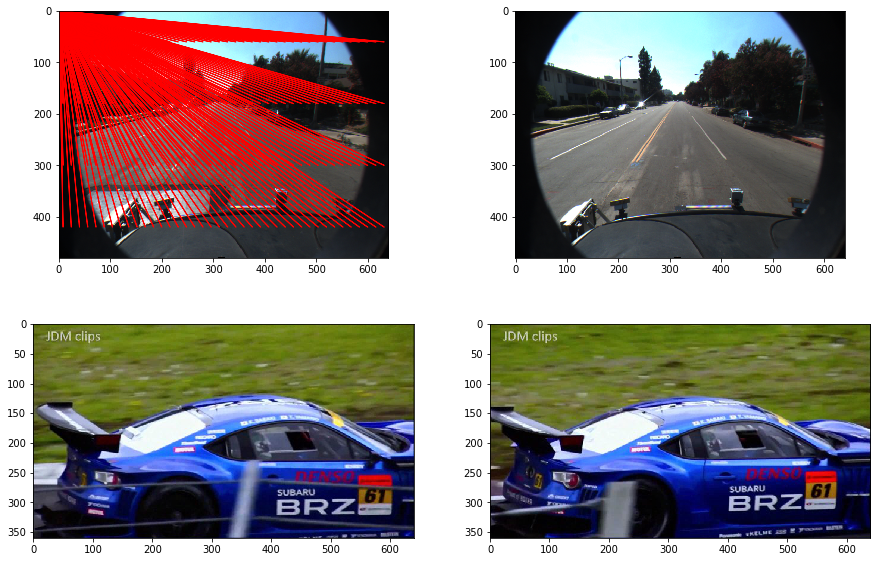

In [44]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, data, feature, color
import numpy as np
import math

def sumSquaredDiff(block1, block2):
    return 0

def findMatch(block, blockLeft, newImage):
    # for lane, 50px neighbourhood
    neighbourhood = 50
    blockWidth = oldImage.shape[1]
    blockHeight = oldImage.shape[0]
    
    minDif = math.inf
    match = block # ToDo safe center
    
    neighbourhoodStartX = max(0, blockLeft[0] -  neighbourhood)
    neighbourhoodStartY = max(0, blockLeft[1] -  neighbourhood)
    
    for x in range(neighbourhood+neighbourhood):
        for y in range(neighbourhood+neighbourhood): # todo Bild cap
            ##oberer Rand, unterer Rand, linkerRand, rechter Rand
            currentNewBlock = newImage[neighbourhoodStartY+y:neighbourhoodStartY+y+blockHeight,
                                       neighbourhoodStartX+x: neighbourhoodStartX+x+blockWidth]
            newDiff = sumSquaredDiff(block, currentNewBlock)
            if newDiff < minDif:
                minDif = newDiff
                match = currentNewBlock # ToDo safe center
    
    return (0,0)

def blockMatching(oldImage, newImage, out=plt):
    image_width = oldImage.shape[1]
    countBlocksX = 40
    blockSizeX = int(math.floor(image_width/countBlocksX))

    image_height = oldImage.shape[0]
    countBlocksY = 4
    blockSizeY = int(math.floor(image_height/countBlocksY))

    for currentBlockX in range(countBlocksX):
        x = currentBlockX * blockSizeX
        for currentBlockY in range(countBlocksY): 
            y = currentBlockY * blockSizeY
            block = oldImage[y:y+blockSizeY, x:x+blockSizeX] #oberer Rand, unterer Rand, linkerRand, rechter Rand
            centerOldX, centerOldY = (x+blockSizeX//2, y+blockSizeY//2)
            centerOfMatchX, centerOfMatchY = findMatch(block, (x, y), newImage)
            dx, dy = (centerOfMatchX-centerOldX, centerOfMatchY - centerOldY)
            out.add_patch(
                patches.Arrow(centerOldX, centerOldY, dx, dy, edgecolor="red")
            )

# chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

car1 = io.imread('images/racecar/100.jpeg')
car2 = io.imread('images/racecar/102.jpeg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

blockMatching(lane1, lane2, ax11)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(car1)
ax22.imshow(car2)

## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)